In [1]:
# Loading in the basics
import psycopg2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from config import password

In [2]:
# Connect to postgres db
ENDPOINT="ucb-data-group-project-zillow.csaw135fqqkl.us-west-1.rds.amazonaws.com"
PORT="5432"
USR="postgres"
REGION="us-west-1"


In [3]:
DBNAME="postgres"

conn = psycopg2.connect(database = DBNAME,
                        user =     USR,
                        password = password,
                        host =     ENDPOINT,
                        port =     PORT)

In [4]:
# zillow final table sql
zillow_final_sql = '''
            SELECT *
            FROM zillow_final;
            '''

In [5]:
# setting up dfs
zillow_final_data_df = pd.read_sql(zillow_final_sql, conn)

In [6]:
# census table sql
census_sql = '''
            SELECT *
            FROM census;
            '''

In [7]:
# setting up dfs
census_data_df = pd.read_sql(census_sql, conn)

In [8]:
zillow_final_data_df

,date,size_rank,region_name,list_price,sale_price,list_divided_by_sale,list_minus_sale
0,2017-11-04,0,United States,275448.0,235099.0,85.351500,40349.0
1,2017-11-11,0,United States,275448.0,234750.0,85.224797,40698.0
2,2017-11-18,0,United States,275448.0,235750.0,85.587842,39698.0
3,2017-11-25,0,United States,274975.0,235916.0,85.795436,39059.0
4,2017-12-02,0,United States,274825.0,237166.0,86.297098,37659.0
...,...,...,...,...,...,...,...
2207,2021-05-22,17,"San Diego, CA",849925.0,745500.0,87.713622,104425.0
2208,2021-05-22,13,"Riverside, CA",536250.0,482000.0,89.883450,54250.0
2209,2021-05-22,11,"San Francisco, CA",995660.0,1092750.0,109.751321,-97090.0
2210,2021-05-22,2,"Los Angeles-Long Beach-Anaheim, CA",999750.0,816125.0,81.632908,183625.0


In [28]:
#full yearly dataframes
df_2017 = zillow_final_data_df.loc[(zillow_final_data_df["date"] >= "2017-01-01") & (zillow_final_data_df["date"] <= "2017-12-31")]
df_2018 = zillow_final_data_df.loc[(zillow_final_data_df["date"] >= "2018-01-01") & (zillow_final_data_df["date"] <= "2018-12-31")]
df_2019 = zillow_final_data_df.loc[(zillow_final_data_df["date"] >= "2019-01-01") & (zillow_final_data_df["date"] <= "2019-12-31")]
df_2020 = zillow_final_data_df.loc[(zillow_final_data_df["date"] >= "2020-01-01") & (zillow_final_data_df["date"] <= "2020-12-31")]
df_2021 = zillow_final_data_df.loc[(zillow_final_data_df["date"] >= "2021-01-01") & (zillow_final_data_df["date"] <= "2021-12-31")]

df_2017

,date,size_rank,region_name,list_price,sale_price,list_divided_by_sale,list_minus_sale
0,2017-11-04,0,United States,275448.0,235099.0,85.351500,40349.0
1,2017-11-11,0,United States,275448.0,234750.0,85.224797,40698.0
2,2017-11-18,0,United States,275448.0,235750.0,85.587842,39698.0
3,2017-11-25,0,United States,274975.0,235916.0,85.795436,39059.0
4,2017-12-02,0,United States,274825.0,237166.0,86.297098,37659.0
...,...,...,...,...,...,...,...
457,2017-12-30,13,"Riverside, CA",391275.0,356438.0,91.096543,34837.0
458,2017-12-30,11,"San Francisco, CA",811943.0,749188.0,92.271009,62755.0
459,2017-12-30,2,"Los Angeles-Long Beach-Anaheim, CA",818914.0,618750.0,75.557385,200164.0
460,2017-12-30,25,"Sacramento, CA",469870.0,393375.0,83.719965,76495.0


In [95]:
# dividing df into regions

df_united_states = zillow_final_data_df.loc[zillow_final_data_df["region_name"] == "United States"]
df_california = zillow_final_data_df.loc[zillow_final_data_df["region_name"] == "California"]
df_california_cities =zillow_final_data_df.loc[(zillow_final_data_df["region_name"] != "United States") & (zillow_final_data_df["region_name"] != "California")]

df_california_cities.head()

,date,size_rank,region_name,list_price,sale_price,list_divided_by_sale,list_minus_sale
372,2017-11-04,17,"San Diego, CA",728005.0,541438.0,74.372841,186567.0
373,2017-11-04,11,"San Francisco, CA",867930.0,781063.0,89.991474,86867.0
374,2017-11-04,13,"Riverside, CA",388757.0,342999.0,88.229665,45758.0
375,2017-11-04,2,"Los Angeles-Long Beach-Anaheim, CA",812252.0,611250.0,75.253739,201002.0
376,2017-11-04,77,"Stockton, CA",408007.0,357875.0,87.712956,50132.0


In [74]:
from fbprophet import Prophet
import numpy as np
from pandas import DataFrame, to_datetime
import seaborn as sns

In [92]:
df["ds"] = df_2017.loc[:, "date"]
df["y"] = df_2017.loc[:, "list_divided_by_sale"]
model = Prophet(yearly_seasonality = True)
# fit the model
model.fit(df)

D:\anaconda\envs\ml_\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
D:\anaconda\envs\ml_\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [93]:
future = list()
for i in range(1, 13):
	date = '2017-%02d' % i
	future.append([date])
future = DataFrame(future)
future.columns = ['ds']
future['ds']= to_datetime(future['ds'])

          ds       yhat  yhat_lower  yhat_upper
0 2017-01-01  93.925495   86.098218  102.406494
1 2017-02-01  92.425378   83.959178   99.727951
2 2017-03-01  91.814448   83.992659   99.586599
3 2017-04-01  90.992726   83.262581   99.076181
4 2017-05-01  90.158765   82.538665   97.853541


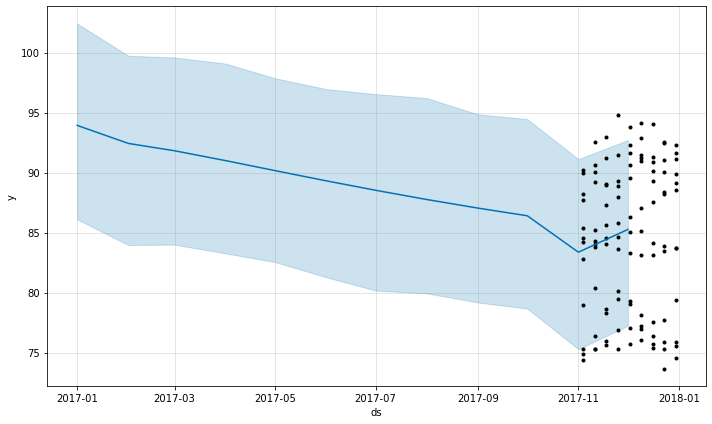

In [94]:
forecast = model.predict(future)
# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
model.plot(forecast)
plt.show()

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout, Flatten,LSTM,RepeatVector,TimeDistributed,Conv1D,MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from livelossplot.tf_keras import PlotLossesCallback
from statsmodels.tsa.seasonal import seasonal_decompose

In [50]:
df["x"] = zillow_final_data_df.loc[:,"list_price"]
df["y"] = zillow_final_data_df.loc[:,"sale_price"]
df.head()

D:\anaconda\envs\ml_\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
D:\anaconda\envs\ml_\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,date,size_rank,region_name,list_price,sale_price,list_divided_by_sale,list_minus_sale,ds,y,x
0,2017-11-04,0,United States,275448.0,235099.0,85.351500,40349.0,2017-11-04,235099.0,275448.0
1,2017-11-11,0,United States,275448.0,234750.0,85.224797,40698.0,2017-11-11,234750.0,275448.0
2,2017-11-18,0,United States,275448.0,235750.0,85.587842,39698.0,2017-11-18,235750.0,275448.0
3,2017-11-25,0,United States,274975.0,235916.0,85.795436,39059.0,2017-11-25,235916.0,274975.0
4,2017-12-02,0,United States,274825.0,237166.0,86.297098,37659.0,2017-12-02,237166.0,274825.0


In [51]:
def train_test_builder(df,size_test=24,length_train_sequence = 24,length_forecast = 12, normalize = False):
    
    train_df = df[:-size_test]    
    
    # create training sets
    train_x,train_y = window_splitter(train_df)
    
    # create test set
    tmp = df[:length_forecast]
    tmp = pd.concat([df,tmp],ignore_index = True)
    tmp[-length_forecast:] = np.nan  # unknown
    test_x,test_y = window_splitter(tmp)
    # drop elements in training
    test_x = test_x[train_x.shape[0]:]
    test_y = test_y[train_x.shape[0]:]
    for i in range(length_forecast):
        test_y[i,:(11-i)]=np.nan # present in training_set
    
    # normalize
    if normalize:
        m = train_df.x.mean()
        sd = train_df.x.std()
        train_x -= m
        train_x/= sd
        test_x -=m
        test_x /= sd
    
    return train_x,train_y,test_x,test_y


# iterate over the time steps and divide the data into overlapping windows; 
def window_splitter(train_df,length_train_sequence = 24,length_forecast = 12):
    i = 0
    x,y = [],[]
    while i + length_train_sequence+ length_forecast < len(train_df):
        x.append(train_df.x[i:(i+length_train_sequence)].values)
        y.append(train_df.x[(i+length_train_sequence):(i+length_train_sequence+length_forecast)].values)
        i+=1

    x = np.array(x).reshape(-1,length_train_sequence,1)
    y = np.array(y).reshape(-1,length_forecast)
    
    return x,y

D:\anaconda\envs\ml_\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  This is separate from the ipykernel package so we can avoid doing imports until


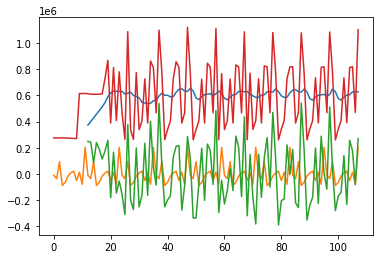

In [53]:
# a naive seasonal decomposition
series = df.x.values
result = seasonal_decompose(series, model='additive',freq=12,two_sided = False,)
plt.plot(result.trend)
plt.plot(result.seasonal)
plt.plot(result.resid)
plt.plot(result.observed)

In [54]:
train_x,train_y,test_x,test_y = train_test_builder(df)

train_x.shape, train_y.shape, test_x.shape, test_y.shape

((48, 24, 1), (48, 12), (36, 24, 1), (36, 12))

In [55]:

# evaluation function
def evaluate_predictions(pred_y, test_y):
    return pd.DataFrame(abs(test_y-pred_y)).mean(skipna = True)


def plot_evaluation(pred_y,test_y,n=12):
    scores = evaluate_predictions(pred_y,test_y)

    print("Mean absolute error test set:",scores.mean())

    plt.figure(figsize=(6,4))
    plt.plot(np.arange(1,13),scores)
    plt.xticks(np.arange(1,13))
    plt.xlabel("horizon [months]", size = 15)
    plt.ylabel("MAE", size = 15)
    plt.title("Scores LSTM on test set")
    plt.show()

    plt.figure(figsize=(6,4))
    plt.title("LSTM forecasting - test set window")
    plt.plot(np.arange(1,13),pred_y[n:(n+1)].reshape(-1,1),label = "predictions")
    plt.plot(np.arange(1,13),test_y[n:(n+1)].reshape(-1,1),label = "true values")
    plt.xticks(np.arange(1,13))
    plt.xlabel("horizon [months]", size = 15)
    plt.legend()
    plt.show()

In [56]:

n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]

# define model
model = Sequential()
model.add(LSTM(256, activation='relu', input_shape=(None, 1)))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(n_outputs))

# compile
model.compile(loss='mse', optimizer= Adam(lr=1e-3), metrics = ["mae"])

# callbacks
early_stopping = EarlyStopping(patience=32, monitor='val_loss', mode='auto', restore_best_weights=True)
callbacks=[PlotLossesCallback(), early_stopping]

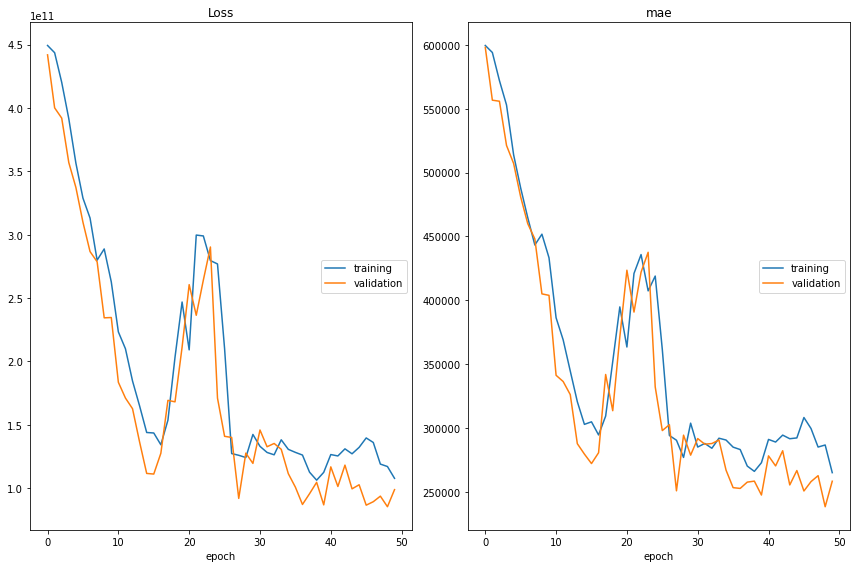

Loss
	training         	 (min: 106359095296.000, max: 449307738112.000, cur: 107810938880.000)
	validation       	 (min: 85409538048.000, max: 441906003968.000, cur: 98890293248.000)
mae
	training         	 (min: 265035.844, max: 599540.062, cur: 265035.844)
	validation       	 (min: 238363.172, max: 598072.312, cur: 258339.875)
38/38 [==============================] - 1s 16ms/sample - loss: 107810938880.0000 - mae: 265035.8438 - val_loss: 98890293248.0000 - val_mae: 258339.8750


In [57]:
model.fit(train_x, train_y, 
          validation_split = 0.2, 
          epochs=50, 
          shuffle = True,
          batch_size=50,
          verbose=1,
          callbacks = callbacks,
         )

Mean absolute error test set: 267729.3745638021


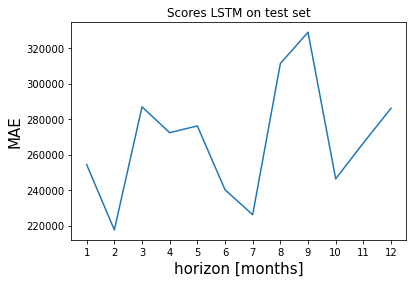

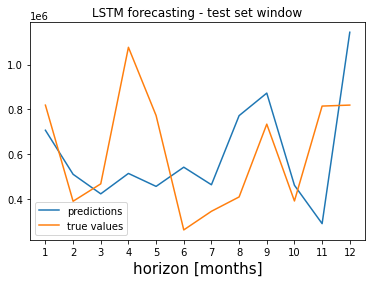

In [49]:
pred_y = model.predict(test_x)
# add seasonality of the past year
for i in np.arange(pred_y.shape[0]-1,-1,-1):
    pred_y[pred_y.shape[0]-1-i] += result.seasonal[-(13+i):-(1+i)]

plot_evaluation(pred_y,test_y,n=12)
